In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR


In [3]:
from data_generation import *
from utils import *
from upscaling import UpScale
from downscaling import *

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N_low = 16
N_high = 64
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

In [23]:
GP_l = 0.1
GP_sigma = 0.1
mean_u, covariance_u = u_prior(GP_l,GP_sigma,N_low)
w_sample = np.random.multivariate_normal(mean_u.ravel(),covariance_u)

Text(0.5, 0.92, 'low-res')

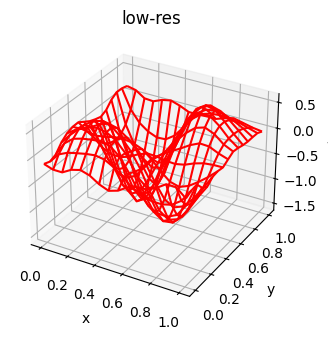

In [24]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low,y_low)
ax1.plot_wireframe(X, Y, w_sample.reshape(16,16),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')

In [25]:
generate_pairs_from_ulow(500,0.1,0.1,16,64,"500_from_ulow_e-1_e-1.h5")

100%|██████████| 500/500 [04:47<00:00,  1.74it/s]


In [7]:
r_high.shape

(4096,)

In [4]:
generate_pairs_from_uhigh(500,1,0.002,17,65,"500_from_uhigh_1_2e-3_1765.h5")

 47%|████▋     | 233/500 [2:00:54<1:25:01, 19.11s/it]

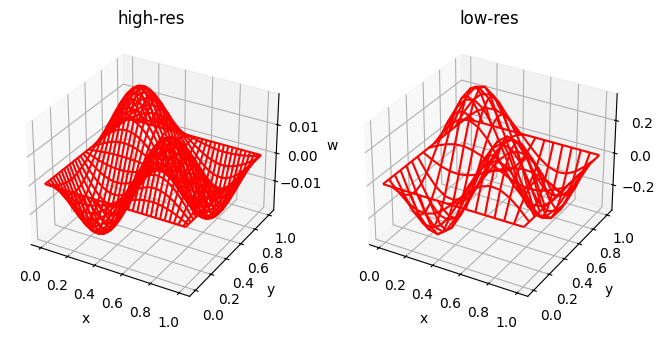

In [8]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, r_high.reshape(64,64),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('high-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_low,y_low)
ax2.plot_wireframe(X, Y, r_low.reshape(16,16),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('low-res')
plt.show()

In [9]:
mean, covariance = u_prior(0.1,0.1,16)

Text(0.5, 0.92, 'high-res')

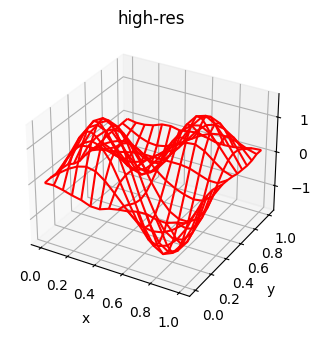

In [43]:
w_sample = np.random.multivariate_normal(mean.ravel(),covariance).reshape(16,16)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_sample,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('high-res')

In [10]:
G = gaussian_kernal(x_low,y_low,0.1,0.1,16)

In [31]:
r_sample = np.random.multivariate_normal(r_low.ravel(),G).reshape(16,16)

Text(0.5, 0.92, 'high-res')

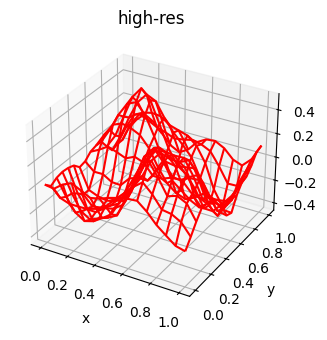

In [32]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, r_sample,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('high-res')

In [5]:
batch_size = 8
trainset = DataFromH5File2("data/500_from_uhigh_1_2e-3.h5")
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i, d in enumerate(train_loader, 0):
    
    if i == 0:
        lr, hr = d
        size = lr.shape[0]
        
        lr = lr.to(device).reshape(size,1,N_low,N_low)
        hr = hr.to(device).reshape(size,1,N_high,N_high)
        
        # Bicubic correction network
        sr_bicubic = F.interpolate(lr, [64, 64], mode='bilinear', align_corners=True)
        
        sr_bicubic = torch.tensor(sr_bicubic).to(torch.float32).to(device).reshape(size,1,N_high,N_high)
        # lr = lr.to(device).reshape(size,1,N_low,N_low)
        hr = hr.to(device).reshape(size,1,N_high,N_high)
    

/tmp/ipykernel_1139721/3015427314.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sr_bicubic = torch.tensor(sr_bicubic).to(torch.float32).to(device).reshape(size,1,N_high,N_high)


In [6]:
sr_bicubic.shape

torch.Size([8, 1, 64, 64])

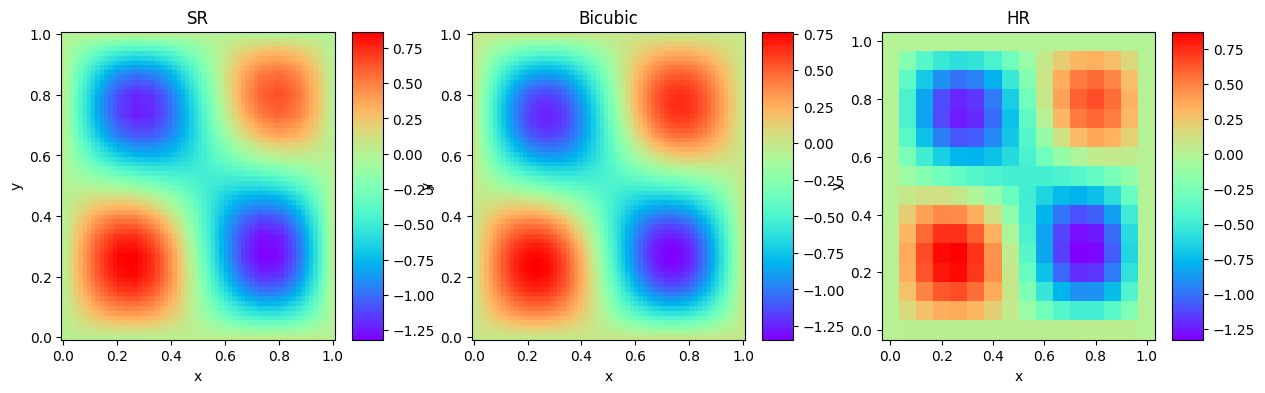

In [7]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, sr_bicubic.cpu().detach().numpy()[4][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, hr.cpu().detach().numpy()[4][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_low, y_low, lr.cpu().detach().numpy()[4][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()